
Teema: Pildifailist teksti tuvastamine ja sellest lühikokkuvõtte tegemine

Ülesande kirjeldus: Kasutaja annab sisendina ette pildifaili. Pildilt tuvastatakse mõne pilditöötlusmudeliga tekst, millest tehakse keelemudeli abil (nt bert-extractive-summarizer teek)  abil n-lauseline lühikokkuvõte, n annab kasutaja sisendina ette. Püüame saada asja tööle eestikeelsetel tekstidel kasutades EstBert mudelit (kui pole võimalik, teeme ingliskeelsetel tekstidel).
Viited:
https://github.com/dmmiller612/bert-extractive-summarizer
https://medium.com/analytics-vidhya/text-summarization-using-bert-gpt2-xlnet-5ee80608e961
medium.com

In [ ]:
#Improdid
# Colabi jaoks vajalikud impordid
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/")


!pip install pytesseract
!sudo apt install tesseract-ocr

# Colabis vajalik teek piltide näitamiseks
from google.colab.patches import cv2_imshow
import cv2 as cv
from PIL import Image
import pytesseract

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


enne jätkamist lae alla [eesti keele training fail](https://github.com/tesseract-ocr/tessdata/blob/main/est.traineddata) ja lae see üles oma drive-i colab kausta (nagu varasemates praksides olnud lisafailid)
ning testimiseks tee enda mingi screenshot vms drive kausta vastava nimega

In [ ]:
# võib erineda
%env TESSDATA_PREFIX=/content/drive/MyDrive/Colab Notebooks

env: TESSDATA_PREFIX=/content/drive/MyDrive/Colab Notebooks


In [ ]:
#Sisendid
path_to_image="Kuvatõmmis.png"
num_sentences_in_summary=5

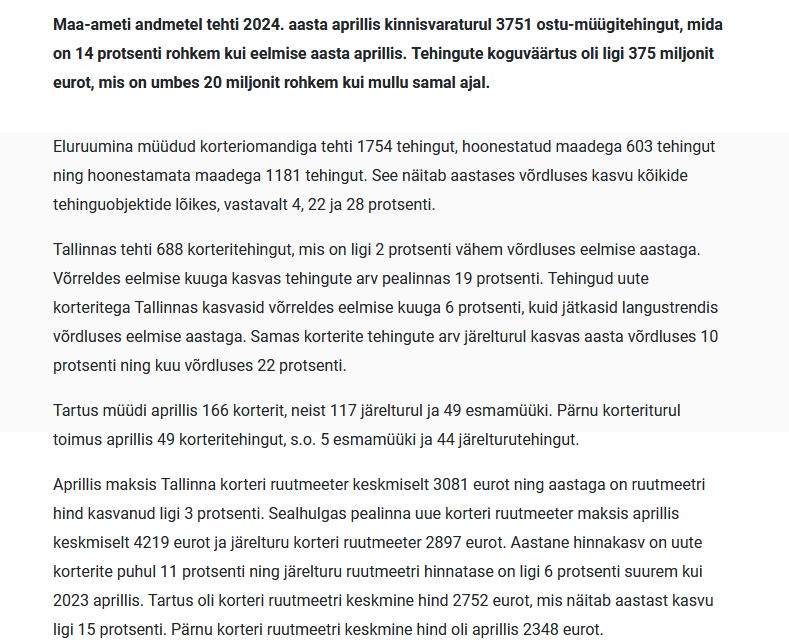

In [ ]:
cv2_imshow(cv.imread(path_to_image))

In [ ]:
#pildilt teksti tuvastamine

extracted_information = pytesseract.image_to_string(Image.open("näidis.png"), lang="est")
print(extracted_information)

FileNotFoundError: [Errno 2] No such file or directory: 'näidis.png'

In [ ]:
!pip install estnltk
!pip install sentence-transformers
import numpy as np
from sklearn.cluster import KMeans
from transformers import AutoTokenizer, AutoModel
import nltk
from nltk.tokenize import sent_tokenize
import torch
from estnltk import Text
from sentence_transformers import SentenceTransformer, models, InputExample, losses

Text summarization methods can be grouped into two main categories: Extractive and Abstractive methods.

Extractive Text Summarization

The traditional method with the main objective to identify the significant sentences of the text and add them to the summary. Note that the summary obtained contains exact sentences from the original text data.

Abstractive Text Summarization

The advanced method, with the approach to identify the important sections, interpret the context and reproduce the text in a new way. This ensures that the core information is conveyed through the shortest text possible. Note that here, the sentences, in summary, are generated by the model, not just extracted from the original text data.

In [ ]:
#Estnltk abil teksti lauseteks jagamine
def split_text_into_sentences(text):
    t = Text(text)
    t.tag_layer(['sentences'])
    sentences = t['sentences']
    sentence_list = [' '.join([word.text for word in sentence.words]) for sentence in sentences]
    #print(sentence_list)
    return sentence_list

BERT (and other transformer networks) output for each token in our input text an embedding. In order to create a fixed-sized sentence embedding out of this, the model applies mean pooling, i.e., the output embeddings for all tokens are averaged to yield a fixed-sized vector.

In [ ]:
#lausete embeddingute leidmine Estbert abil
#https://www.geeksforgeeks.org/how-to-generate-word-embedding-using-bert/

def generate_sentence_embeddings(sentences):
    # Laadime EstBERT-i tokenizeri ja mudeli
    tokenizer = AutoTokenizer.from_pretrained('tartuNLP/EstBERT')
    model = AutoModel.from_pretrained('tartuNLP/EstBERT')

    # Tokenize sentences and convert to input IDs
    inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True)

    # Compute embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Use the average of the last hidden state as sentence embeddings
    embeddings = outputs.last_hidden_state.mean(dim=1).numpy()

    return embeddings



In [ ]:
#embeddingute k-means klasterdamine
def k_means_clustering(embeddings, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(embeddings)
    print(kmeans.labels_) #prindib välja, millisesse klastrisse laused kuuluvad
    return kmeans.labels_

In [ ]:

#põhiline funktsioon - teeb kokkuvõtte tekstist
def summarize_text(text, summary_length):

    #tekst lausete listiks
    sentences = split_text_into_sentences(text)

    #igast lausest embedding
    embeddings = generate_sentence_embeddings(sentences)


    # klasterdamine, tagastab listi kus on klastri numbrid samas järjekorras nagu laused ette anti, teeme nii mitu klastrit, kui mitut lauset kokkuvõttesse tahame
    labels = k_means_clustering(embeddings, summary_length)

    for i in range(len(sentences)):
        print ("Klastrisse "+ str (labels[i]) + " määrati lause "+sentences[i])

    # kokkuvõtte tegmiseks võtame klastrite kõige esinduslikumad laused iga klastri kõige esinduslikum võiks olla see, mis on kõige rohkem keskel (seda kasutavad ka teised summarizerid)
    #todo - vaadata üle, kas see klastri kõige keskmise leidja üldse teeb mida peaks
    centroids = []
    for cluster in range(summary_length):
        cluster_indices = np.where(labels == cluster)[0]
        cluster_embeddings = embeddings[cluster_indices]
        centroid = np.mean(cluster_embeddings, axis=0)
        centroids.append(centroid)

    summary = []
    for centroid in centroids:
        distances = [np.linalg.norm(embedding - centroid) for embedding in embeddings]
        closest_index = np.argmin(distances)
        closest_sentence = sentences[closest_index]
        summary.append(closest_sentence)

    return ' '.join(summary)



text = """
Tehisintellektiga pildituvastus on kaasaegne tehnoloogia, mis võimaldab arvutil automaatselt tuvastada ja klassifitseerida pilte.
Pildituvastus tehisintellekti abil leidub mitmetes rakendustes, alates näotuvastusest kuni objektide ja stseenide tuvastamiseni.
Üks peamisi eeliseid tehisintellektiga pildituvastuses on selle võime töödelda ja analüüsida suuri andmemahte kiiresti ja täpselt.
Lisaks saab tehisintellektiga pildituvastust kasutada autonoomsetes sõidukites, meditsiinilistes diagnoosides ja turvaseadmetes.
Pildituvastus tehisintellekti abil võib aidata ka näiteks loomade jälgimisel looduses või jälgida tööstuslike protsesside kulgu.
See tehnoloogia võimaldab arvutil tõhusalt tuvastada ja eristada erinevaid objekte, isegi keerulistes ja muutuvates keskkondades.
Tehisintellektiga pildituvastuse täpsus ja usaldusväärsus on pidevalt paranenud tänu sügavate õppemudelite arengule ja suurema andmekogumi kättesaadavusele.
Selle tehnoloogia aluseks on sügavad õppemudelid, nagu näiteks konvolutsioonilised neurovõrgud, mis suudavad õppida visuaalseid tunnuseid otse piltidest.
Kuigi tehisintellektiga pildituvastusel on palju kasutusvõimalusi, tuleb arvesse võtta ka privaatsuse ja eetilisi küsimusi seoses isikuandmete töötlemisega.
Kokkuvõttes võib öelda, et tehisintellektiga pildituvastus on dünaamiline valdkond, mis jätkab kiiret arengut ja pakub palju võimalusi erinevates valdkondades.
"""

num_clusters = 2
summary = summarize_text(text, num_clusters)
print(summary)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/410k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at tartuNLP/EstBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 1 0 1 0 1 1 1 1 0]
Klastrisse 1 määrati lause Tehisintellektiga pildituvastus on kaasaegne tehnoloogia , mis võimaldab arvutil automaatselt tuvastada ja klassifitseerida pilte .
Klastrisse 1 määrati lause Pildituvastus tehisintellekti abil leidub mitmetes rakendustes , alates näotuvastusest kuni objektide ja stseenide tuvastamiseni .
Klastrisse 0 määrati lause Üks peamisi eeliseid tehisintellektiga pildituvastuses on selle võime töödelda ja analüüsida suuri andmemahte kiiresti ja täpselt .
Klastrisse 1 määrati lause Lisaks saab tehisintellektiga pildituvastust kasutada autonoomsetes sõidukites , meditsiinilistes diagnoosides ja turvaseadmetes .
Klastrisse 0 määrati lause Pildituvastus tehisintellekti abil võib aidata ka näiteks loomade jälgimisel looduses või jälgida tööstuslike protsesside kulgu .
Klastrisse 1 määrati lause See tehnoloogia võimaldab arvutil tõhusalt tuvastada ja eristada erinevaid objekte , isegi keerulistes ja muutuvates keskkondades .
Klastrisse 1 määrati lause T

In [ ]:
#kokkuvõtte tegemine

testisin chatgptga mingit lahendust mis ilmselt on samasugune mis ülal juba varasemalt  
-kennar

In [ ]:
def split_text(text):
  est_text = Text(text).tag_layer('sentences')
  sentences = [(' '.join(word for word in sentence)) for sentence in est_text['sentences']['text']]
  return sentences

In [ ]:
from transformers import BertTokenizer, BertModel
def get_embeddings(sentences):
  model_name = 'tartuNLP/EstBERT'
  tokenizer = BertTokenizer.from_pretrained(model_name)
  model = BertModel.from_pretrained(model_name)

  embeddings = []
  for sentence in sentences:
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    embeddings.append(outputs.last_hidden_state.mean(dim=1).detach().numpy())

  return embeddings

In [ ]:

from sklearn.metrics.pairwise import cosine_similarity

def get_summary(embeddings, sentences, num_sentences=3):
  # Compute similarity of each sentence with the entire text
  text_embedding = np.mean(embeddings, axis=0)
  similarities = [cosine_similarity(emb, text_embedding) for emb in embeddings]

  # Rank sentences by similarity and select top ones
  ranked_sentences = [sent for _, sent in sorted(zip(similarities, sentences), key=lambda x: x[0], reverse=True)]
  summary = '\n'.join(ranked_sentences[:num_sentences])

  return summary

In [ ]:
def generate_summary(text, num_sentences=3):
  sentences = split_text(text)
  embeddings = get_embeddings(sentences)
  summary = get_summary(embeddings, sentences, num_sentences)
  return summary

In [ ]:
text = """
Eesti otsusele toetada 10. mail ÜRO Peaassambleel resolutsiooni, mis tõstab Palestiina vaatlejariigi positsiooni maailmaorganisatsioonis ning kutsub talle pakkuma täisliikme staatust, eelnes peaministri ja välisministri põhjalik suhtlus Põhjamaade ja Balti riikide esindajatega.
"Eesti suursaadik ÜRO juures hääletas nii, nagu seda nägi ette Vabariigi Valitsuse otsus," ütles ERR-ile Carlos Kleimann valitsuse kommunikatsioonibüroost.
Enne hääletuse toimumist suhtles peaminister Kaja Kallas (Reformierakond) sel teemal Läti, Leedu, Soome, Rootsi ja Norra peaministritega.
ERR küsis, kas Kallas soovitas nendel riigijuhtidel hääletusel poolt hääletada.
"On tavapärane, et koordineerime ja tutvustame seisukohti oma lähimate partneritega. Mõistagi on nii meile kui ka teistele riikidele oluline Põhja-Balti regiooni ühtsus, nii on loomulikuks sihiks ühisele positsioonile jõudmine. Selles valguses tutvustas ka peaminister Eesti kaalutlusi mitmele kolleegile. On hea tava ja austus partnerite vastu seda suhtlust avalikkuses mitte avaldada," vastas Kleimann.
Kleimann rääkis, et Eesti tegi läbimõeldud otsuse.
"Muutunud on geopoliitiline olukord meie ümber –  Eesti julgeolekule on kasvavalt oluline, et sõda Lähis-Idas ei eskaleeruks veelgi enam ja et Iisraeli-Palestiina konfliktile leitaks lahendus. Meile on eksistentsiaalselt oluline, et muude konfliktide varjus ei saaks Venemaa oma agressiooni Ukraina vastu tugevdada. Niisama tähtis on see, et globaalne toetus Ukrainale kasvaks ja et meid ei oleks põhjust süüdistada topeltstandardites, ega selles, et me oleme keskendunud Ukraina toetamisele. Selleks ühines Eesti 142 ÜRO liikmesriigiga ja saatis signaali, et Lähis-Ida poliitilist protsessi tuleb tagant tõugata ning sellega tuleb kiirelt edasi liikuda," loetles Kleimann.
"Eesti on pikaaegselt toetanud seda, et Palestiina saaks oma riigi ehk toetame kahe riigi lahendust Lähis-Ida konfliktis. Resolutsioonist ei tulene Palestiina tunnustamine. Palestiina tunnustamine on eraldiseisev protsess, milleks on vaja Vabariigi Valitsuse otsust," lisas ta.
Eesti hääletas 10. mail New Yorgis peetud ÜRO Peaassambleel resolutsiooni poolt, mis tõstab Palestiina vaatlejariigi positsiooni maailmaorganisatsioonis ning kutsub talle pakkuma täisliikme staatust.
Euroopa Liit läks hääletusel pooleks: 14 riiki toetasid resolutsiooni, 11 jäi erapooletuks ja kaks olid vastu. Ungari ja Tšehhi - hääletasid selle vastu. Eestiga sarnaselt hääletasid resolutsiooni poolt Belgia, Küpros, Taani, Prantsusmaa, Kreeka, Iirimaa, Luksemburg, Poola, Portugal, Slovakkia, Sloveenia, Hispaania ja Malta. Eesti lähinaabrid Läti, Leedu, Soome ja Rootsi jäid erapooletuks.

Endine välisminister, opositsioonilise erakonna Isamaa esimees Urmas Reinsalu nägi Eesti otsuses olulist muutust Eesti välispoliitikas.
Reinsalu ütles, et varasemalt välisministrina andis ta välisministeeriumis selge juhise, et kui EL-i riikide seisukohad on selles valdkonnas ÜRO-s lõhki, siis Eesti ei hääleta USA seisukoha vastu.
Reeglina on Eesti välispoliitiline liin olnud selline, et Eesti hääletas ÜRO hääletustel koos Euroopa Liiduga, aga kui Euroopa Liit on antud küsimuses pooleks, siis hääletab Eesti koos USA-ga või jääb erapooletuks.
Ka SDE-sse kuuluv endine välisminister ja diplomaat, eurosaadik Marina Kaljurand (SDE) ütles, et Eesti tegi hääletusega oma senises poliitikas muutuse ning tema oleks hoidnud senist joont.
"Ilmselt minu soovitus oleks olnud jätkata vana poliitikaga, aga kui see niimoodi tehti, siis ma ei näe selles katastroofi," ütles Kaljurand ERR-i uudisteportaali "Otse uudistemajast" erisaates.
"Ma ei näe selles väga suurt probleemi. Jah, Eesti välispoliitika on olnud selline, et toetame Euroopa Liitu, kui Euroopa Liit on lõhki, siis hääletame nii nagu Ameerika Ühendriigid. Praegu on tehtud väike nihe, suur nihe oleks siis, kui me oleks praegu koos kolme riigiga tunnustanud Palestiina riiki," lisas Kaljurand.

"""

# Generate summary
summary = generate_summary(text, num_sentences=1)
print("Original Text:\n", text)
print("\nSummary:\n", summary)

Some weights of BertModel were not initialized from the model checkpoint at tartuNLP/EstBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Original Text:
 
Eesti otsusele toetada 10. mail ÜRO Peaassambleel resolutsiooni, mis tõstab Palestiina vaatlejariigi positsiooni maailmaorganisatsioonis ning kutsub talle pakkuma täisliikme staatust, eelnes peaministri ja välisministri põhjalik suhtlus Põhjamaade ja Balti riikide esindajatega.
"Eesti suursaadik ÜRO juures hääletas nii, nagu seda nägi ette Vabariigi Valitsuse otsus," ütles ERR-ile Carlos Kleimann valitsuse kommunikatsioonibüroost.
Enne hääletuse toimumist suhtles peaminister Kaja Kallas (Reformierakond) sel teemal Läti, Leedu, Soome, Rootsi ja Norra peaministritega.
ERR küsis, kas Kallas soovitas nendel riigijuhtidel hääletusel poolt hääletada.
"On tavapärane, et koordineerime ja tutvustame seisukohti oma lähimate partneritega. Mõistagi on nii meile kui ka teistele riikidele oluline Põhja-Balti regiooni ühtsus, nii on loomulikuks sihiks ühisele positsioonile jõudmine. Selles valguses tutvustas ka peaminister Eesti kaalutlusi mitmele kolleegile. On hea tava ja austus pa